In [1]:
try:
    import evaluate
except:
    !pip install evaluate
    import evaluate

import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from torch.optim import AdamW
from datasets import load_dataset
from IPython.display import display
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification, 
                          DataCollatorWithPadding,
                          TrainingArguments,
                          Trainer,
                          get_scheduler)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudn

2025-06-29 20:33:26.646758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751229206.829710      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751229206.884179      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = load_dataset("cornell-movie-review-data/rotten_tomatoes")

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [4]:
data["train"].to_pandas()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
prep_data = data.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True).remove_columns(["text"])

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [7]:
prep_data

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
accuracy, f1 = evaluate.load("accuracy"), evaluate.load("f1")

def ComputeMetrics(models_pred):
    logits, labels = models_pred
    pred = np.argmax(logits, axis=-1)
    return {
        "accuracy":accuracy.compute(predictions=pred, references=labels)["accuracy"],
        "f1_score":f1.compute(predictions=pred, references=labels)["f1"]
    }

In [11]:
training_args = TrainingArguments(output_dir="model",
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  report_to="none", 
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  num_train_epochs=5,
                                  eval_strategy="epoch",
                                  logging_strategy="epoch")

model_trainer = Trainer(model=model,
                        args=training_args,
                        data_collator=data_collator,
                        train_dataset=prep_data["train"],
                        eval_dataset=prep_data["validation"],
                        compute_metrics=ComputeMetrics)

In [12]:
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.424900,0.349022,0.850844,0.857143
2,0.261700,0.341748,0.853659,0.853659
3,0.165100,0.409098,0.848968,0.846813
4,0.103400,0.491075,0.859287,0.856046
5,0.075000,0.537906,0.857411,0.856604


TrainOutput(global_step=1335, training_loss=0.2060230440861277, metrics={'train_runtime': 191.6368, 'train_samples_per_second': 222.556, 'train_steps_per_second': 6.966, 'total_flos': 859625450645520.0, 'train_loss': 0.2060230440861277, 'epoch': 5.0})

In [56]:
def EvaluateTrainer(test_dataset, model):
    output = model.predict(test_dataset)
    labels, pred = output.label_ids, np.argmax(output.predictions, axis=-1)

    display(pd.DataFrame([output.metrics]))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax = ax.flatten()
    
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=pred), 
                annot=True, 
                ax=ax[0], 
                fmt='d')
    
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xticklabels(["class:0", "class:1"])
    ax[0].set_yticklabels(["class:0", "class:1"])

    fpr, tpr, _ = roc_curve(y_true=labels, y_score=output.predictions[:,1])
    auc_score = auc(fpr, tpr)

    ax[1].plot(fpr, tpr, label=f"auc_score={auc_score}")
    ax[1].plot([0, 1], [0, 1], linestyle="--", color="k")
    ax[1].set_title("Roc Auc Curve")
    ax[1].set_xlabel("False Positive")
    ax[1].set_ylabel("True Positive")

    plt.tight_layout()
    plt.show()

,test_loss,test_accuracy,test_f1_score,test_runtime,test_samples_per_second,test_steps_per_second
0,0.602725,0.838649,0.837429,1.2058,884.063,28.197


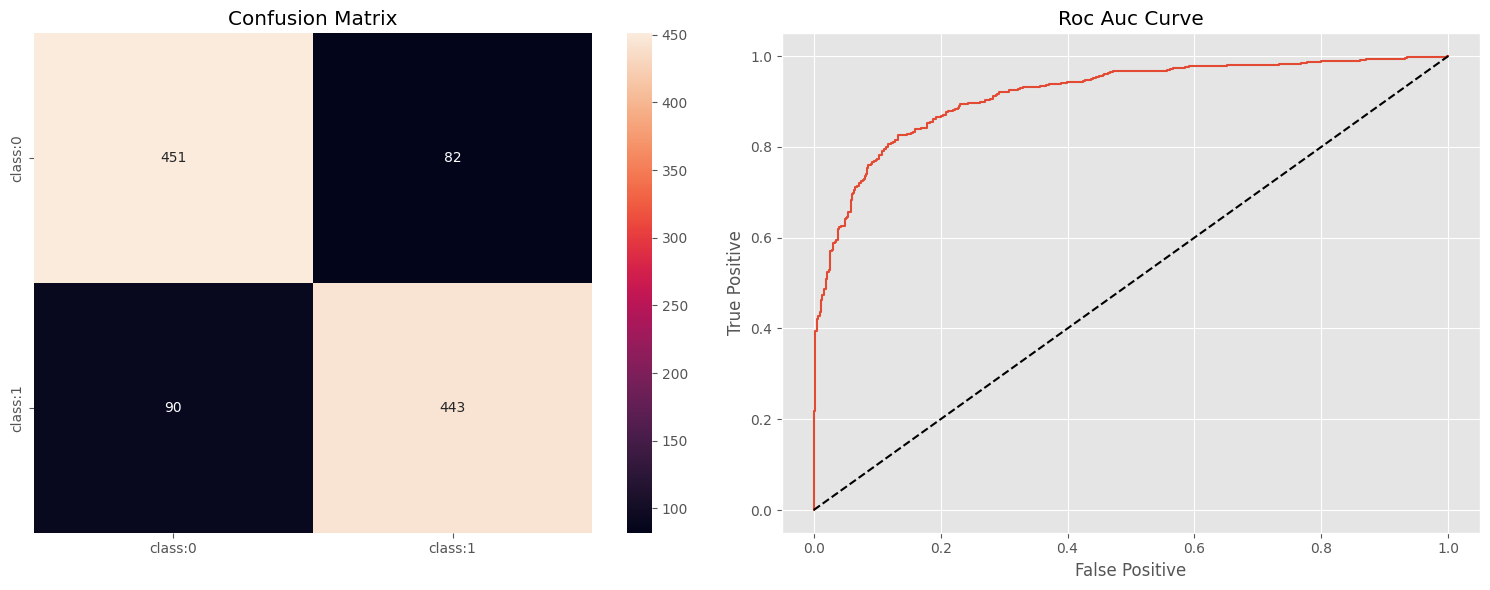

In [57]:
EvaluateTrainer(test_dataset=prep_data["test"], model=model_trainer)

#### Hyperparameter Tunning

In [15]:
finetuned_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for idx, (name, param) in enumerate(finetuned_model.named_parameters()):
    print(f"Index: {idx} --", f"Layer name: {name} -- ", f"IsTrainable: {param.requires_grad}")

Index: 0 -- Layer name: distilbert.embeddings.word_embeddings.weight --  IsTrainable: True
Index: 1 -- Layer name: distilbert.embeddings.position_embeddings.weight --  IsTrainable: True
Index: 2 -- Layer name: distilbert.embeddings.LayerNorm.weight --  IsTrainable: True
Index: 3 -- Layer name: distilbert.embeddings.LayerNorm.bias --  IsTrainable: True
Index: 4 -- Layer name: distilbert.transformer.layer.0.attention.q_lin.weight --  IsTrainable: True
Index: 5 -- Layer name: distilbert.transformer.layer.0.attention.q_lin.bias --  IsTrainable: True
Index: 6 -- Layer name: distilbert.transformer.layer.0.attention.k_lin.weight --  IsTrainable: True
Index: 7 -- Layer name: distilbert.transformer.layer.0.attention.k_lin.bias --  IsTrainable: True
Index: 8 -- Layer name: distilbert.transformer.layer.0.attention.v_lin.weight --  IsTrainable: True
Index: 9 -- Layer name: distilbert.transformer.layer.0.attention.v_lin.bias --  IsTrainable: True
Index: 10 -- Layer name: distilbert.transformer.laye

In [17]:
for idx, (name, param) in enumerate(finetuned_model.named_parameters()):
    if name.startswith(("pre_classifier", "classifier", "distilbert.transformer.layer.4", "distilbert.transformer.layer.5")):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [18]:
for idx, (name, param) in enumerate(finetuned_model.named_parameters()):
    print(f"Index: {idx} --", f"Layer name: {name} -- ", f"IsTrainable: {param.requires_grad}")

Index: 0 -- Layer name: distilbert.embeddings.word_embeddings.weight --  IsTrainable: False
Index: 1 -- Layer name: distilbert.embeddings.position_embeddings.weight --  IsTrainable: False
Index: 2 -- Layer name: distilbert.embeddings.LayerNorm.weight --  IsTrainable: False
Index: 3 -- Layer name: distilbert.embeddings.LayerNorm.bias --  IsTrainable: False
Index: 4 -- Layer name: distilbert.transformer.layer.0.attention.q_lin.weight --  IsTrainable: False
Index: 5 -- Layer name: distilbert.transformer.layer.0.attention.q_lin.bias --  IsTrainable: False
Index: 6 -- Layer name: distilbert.transformer.layer.0.attention.k_lin.weight --  IsTrainable: False
Index: 7 -- Layer name: distilbert.transformer.layer.0.attention.k_lin.bias --  IsTrainable: False
Index: 8 -- Layer name: distilbert.transformer.layer.0.attention.v_lin.weight --  IsTrainable: False
Index: 9 -- Layer name: distilbert.transformer.layer.0.attention.v_lin.bias --  IsTrainable: False
Index: 10 -- Layer name: distilbert.transf

In [19]:
training_args = TrainingArguments(output_dir="model",
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  report_to="none", 
                                  learning_rate=1e-5,
                                  weight_decay=0.01,
                                  num_train_epochs=5,
                                  eval_strategy="epoch",
                                  logging_strategy="epoch")

fine_tuned_model_trainer = Trainer(model=finetuned_model,
                                   args=training_args,
                                   data_collator=data_collator,
                                   train_dataset=prep_data["train"],
                                   eval_dataset=prep_data["validation"],
                                   compute_metrics=ComputeMetrics)

In [20]:
fine_tuned_model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.589900,0.414566,0.826454,0.826941
2,0.412800,0.380028,0.833021,0.831758
3,0.387400,0.372557,0.834897,0.833333
4,0.378900,0.368771,0.835835,0.829932
5,0.370500,0.367862,0.837711,0.832850


TrainOutput(global_step=670, training_loss=0.42788206071995977, metrics={'train_runtime': 94.9394, 'train_samples_per_second': 449.234, 'train_steps_per_second': 7.057, 'total_flos': 860701748259600.0, 'train_loss': 0.42788206071995977, 'epoch': 5.0})

,test_loss,test_accuracy,test_f1_score,test_runtime,test_samples_per_second,test_steps_per_second
0,0.402374,0.824578,0.822412,1.1364,938.031,14.959


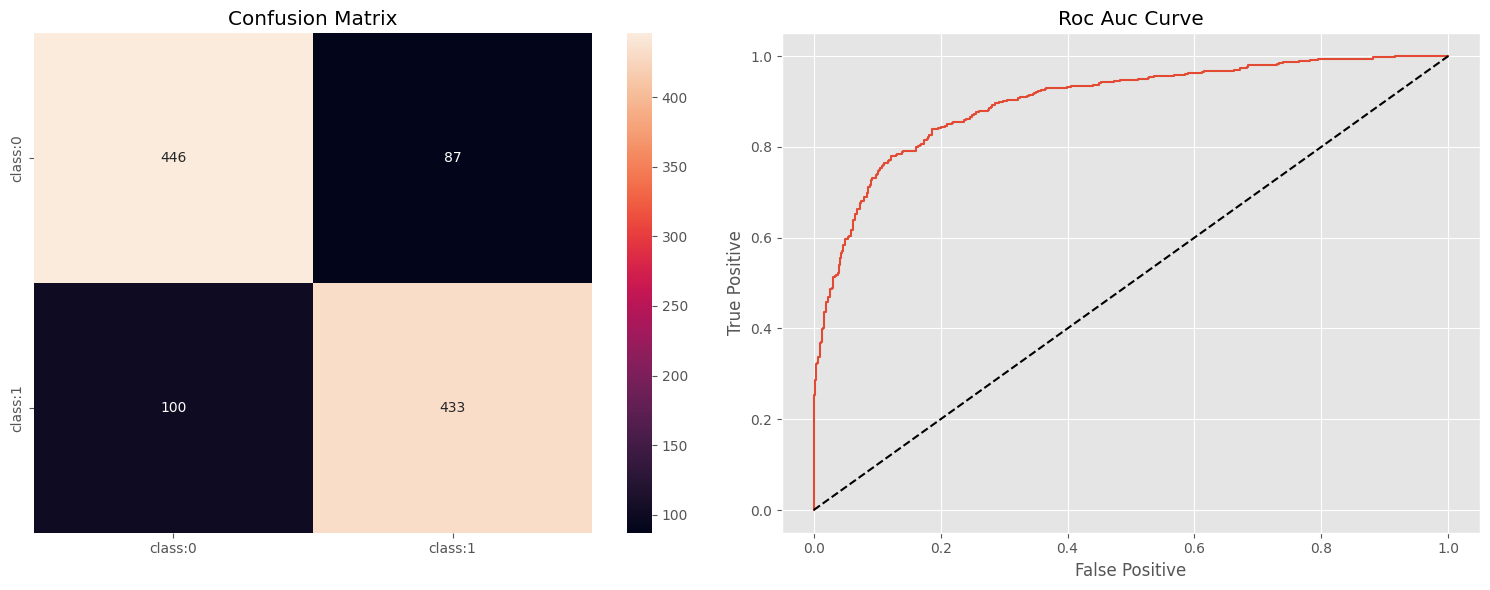

In [58]:
EvaluateTrainer(test_dataset=prep_data["test"], model=fine_tuned_model_trainer)

#### Train Using Pytorch

In [89]:
prep_data.set_format("pytorch")

In [99]:
train_dataloader = DataLoader(dataset=prep_data["train"],
                              batch_size=32, 
                              shuffle=True, 
                              collate_fn=data_collator)

val_dataloader = DataLoader(dataset=prep_data["validation"],
                            batch_size=32, 
                            shuffle=False, 
                            collate_fn=data_collator)

test_dataloader = DataLoader(dataset=prep_data["test"],
                            batch_size=32, 
                            shuffle=False, 
                            collate_fn=data_collator)

In [100]:
torch_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

torch_model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [101]:
import copy

class EarlyStopping:
    def __init__(self, min_delta=1e-4, patience=2):
        self.min_delta = min_delta
        self.patience = patience
        self.best_score = float("inf")
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_score - self.min_delta:
            self.counter = 0
            self.best_score = val_loss
            self.best_state_dict = copy.deepcopy(model.state_dict())
        else:
            self.counter+=1
            if self.counter >= self.patience:
                self.early_stop=True

In [102]:
class PytorchTrainer:
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def train(self):
        for epoch in range(self.kwargs["epochs"]):
            training_progress = tqdm(self.kwargs["train_dataloader"], 
                                     total=len(self.kwargs["train_dataloader"]), 
                                     desc=f"Epoch {epoch+1}/{self.kwargs['epochs']} -- Training")

            total_loss_train = 0
            train_preds_per_epoch = []
            train_labels_per_epoch = []
            
            for train_batch in training_progress:
                self.kwargs["model"].train()
                # Clear accumulated gradient
                self.kwargs["optimizer"].zero_grad()
                model = self.kwargs["model"].to(self.kwargs["device"])
                model_input = {i:j.to(self.kwargs["device"]) for i, j in train_batch.items()}
                # Forward pass
                output = model(**model_input)
                loss = output.loss
                
                pred = torch.argmax(output.logits, dim=-1)

                train_preds_per_epoch.extend(pred.cpu().numpy())
                train_labels_per_epoch.extend(train_batch["labels"].cpu().numpy())
                
                total_loss_train+=loss.item()
                # Backward pass
                loss.backward()
                # Update models parameters
                self.kwargs["optimizer"].step()

                if self.kwargs["lr_scheduler"] is not None:
                    self.kwargs["lr_scheduler"].step()

            train_accuracy = self.kwargs["accuracy"].compute(predictions=train_preds_per_epoch, references=train_labels_per_epoch)["accuracy"]
            train_f1_score = self.kwargs["f1_score"].compute(predictions=train_preds_per_epoch, references=train_labels_per_epoch)["f1"]
            train_average_loss = total_loss_train / len(self.kwargs["train_dataloader"])

            total_loss_val = 0
            val_preds_per_epoch = []
            val_labels_per_epoch = []

            validation_progress = tqdm(self.kwargs["val_dataloader"],
                                       total=len(self.kwargs["val_dataloader"]),
                                       desc= "Validation")
            
            for val_batch in validation_progress:
                self.kwargs["model"].eval()

                with torch.no_grad():
                    model = self.kwargs["model"].to(self.kwargs["device"])
                    model_input = {i:j.to(self.kwargs["device"]) for i, j in val_batch.items()}
                    # Forward pass
                    output = model(**model_input)
                    loss = output.loss
                    
                    pred = torch.argmax(output.logits, dim=-1)
    
                    val_preds_per_epoch.extend(pred.cpu().numpy())
                    val_labels_per_epoch.extend(val_batch["labels"].cpu().numpy())
                    
                    total_loss_val+=loss.item()

            val_accuracy = self.kwargs["accuracy"].compute(predictions=val_preds_per_epoch, references=val_labels_per_epoch)["accuracy"]
            val_f1_score = self.kwargs["f1_score"].compute(predictions=val_preds_per_epoch, references=val_labels_per_epoch)["f1"]
            val_average_loss = total_loss_val / len(self.kwargs["val_dataloader"])
                        
            print("--"*50)
            print("Train accuracy: {} -- Train f1_score: {} -- Train loss: {}".format(train_accuracy, train_f1_score, train_average_loss))
            print("Validation accuracy: {} -- Validation f1_score: {} -- Validation loss: {}".format(val_accuracy, val_f1_score, val_average_loss))
            print(f"Learning Rate: {self.kwargs['lr_scheduler'].optimizer.param_groups[0]['lr']}")
            print("--"*50, end="\n")

            self.kwargs["earlystopping"](val_loss=val_average_loss, 
                                         model=self.kwargs["model"])
            if self.kwargs["earlystopping"].early_stop:
                print("Triggering Early Stopping")
                best_state_dict = self.kwargs["earlystopping"].best_state_dict
                self.kwargs["model"].load_state_dict(best_state_dict)
                return self.kwargs["model"]

    def evaluate(self, dataset=None):
        if dataset is None:
            data = self.kwargs["val_dataloader"]
            evaluating_progress = tqdm(data, 
                                       total=len(data), 
                                        desc="Evaluating")
        else:
            data = dataset
            evaluating_progress = tqdm(data, 
                                       total=len(data), 
                                        desc="Evaluating")
        loss = 0
        eval_pred = []
        eval_label = []
        eval_logit = []
        for batch in evaluating_progress:
            self.kwargs["model"].eval()
            with torch.no_grad():
                model = self.kwargs["model"].to(self.kwargs["device"])
                model_input = {i:j.to(self.kwargs["device"]) for i, j in batch.items()}
                output = model(**model_input)
                y_pred = torch.argmax(output.logits, dim=-1)
                loss += output.loss.item()
                
                eval_label.extend(batch["labels"].cpu().numpy())
                eval_pred.extend(y_pred.cpu().numpy())
                eval_logit.extend(output.logits.cpu().numpy())
                
        eval_accuracy = self.kwargs["accuracy"].compute(predictions=eval_pred, references=eval_label)["accuracy"]
        eval_f1_score = self.kwargs["f1_score"].compute(predictions=eval_pred, references=eval_label)["f1"]
        eval_loss = loss / len(data)

        print("Validation accuracy: {} -- Validation f1_score: {} -- Validation loss: {}".format(eval_accuracy, eval_f1_score, eval_loss))

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        ax = ax.flatten()
    
        sns.heatmap(confusion_matrix(y_true=eval_label, y_pred=eval_pred), 
                    annot=True, 
                    ax=ax[0], 
                    fmt='d')
    
        ax[0].set_title("Confusion Matrix")
        ax[0].set_xticklabels(["class:0", "class:1"])
        ax[0].set_yticklabels(["class:0", "class:1"])

        probabilities = torch.softmax(torch.tensor(np.array(eval_logit)), dim=-1).numpy()
        fpr, tpr, _ = roc_curve(y_true=eval_label, y_score=probabilities[:,1])
        auc_score = auc(fpr, tpr)
    
        ax[1].plot(fpr, tpr, label=f"auc_score={auc_score}")
        ax[1].plot([0, 1], [0, 1], linestyle="--", color="k")
        ax[1].set_title("Roc Auc Curve")
        ax[1].set_xlabel("False Positive")
        ax[1].set_ylabel("True Positive")
    
        plt.tight_layout()
        plt.show()

In [103]:
num_epochs = 10
num_training_steps = (num_epochs * len(train_dataloader)) // 2
num_warmup_steps = int(0.1 * num_training_steps) 

In [104]:
optimizer = AdamW(params=torch_model.parameters(), lr=2e-5)
earlystopping = EarlyStopping()

training_arg = {
    "epochs":num_epochs,
    "model":torch_model,
    "train_dataloader": train_dataloader,
    "val_dataloader": val_dataloader,
    "optimizer":optimizer,
    "accuracy":accuracy,
    "f1_score":f1,
    "device":"cuda:0",
    "earlystopping":earlystopping,
    "lr_scheduler":get_scheduler(name="linear", 
                   optimizer=optimizer,
                   num_warmup_steps=num_warmup_steps,
                   num_training_steps=num_training_steps)
}

pytorch_trainer = PytorchTrainer(**training_arg)

In [105]:
trained_torch_model = pytorch_trainer.train()

Epoch 1/10 -- Training:   0%|          | 0/267 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Train accuracy: 0.7533411488862837 -- Train f1_score: 0.7344775365976779 -- Train loss: 0.4848610691809922
Validation accuracy: 0.8377110694183865 -- Validation f1_score: 0.8369462770970783 -- Validation loss: 0.35045450750519247
Learning Rate: 1.777038269550749e-05
----------------------------------------------------------------------------------------------------


Epoch 2/10 -- Training:   0%|          | 0/267 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Train accuracy: 0.8954279015240328 -- Train f1_score: 0.894137194398291 -- Train loss: 0.26868783442603517
Validation accuracy: 0.8480300187617261 -- Validation f1_score: 0.8457142857142856 -- Validation loss: 0.3368176497957286
Learning Rate: 1.3327787021630617e-05
----------------------------------------------------------------------------------------------------


Epoch 3/10 -- Training:   0%|          | 0/267 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Train accuracy: 0.9432590855803048 -- Train f1_score: 0.9427354472314244 -- Train loss: 0.15589125637899848
Validation accuracy: 0.8536585365853658 -- Validation f1_score: 0.8581818181818182 -- Validation loss: 0.3761008412522428
Learning Rate: 8.885191347753745e-06
----------------------------------------------------------------------------------------------------


Epoch 4/10 -- Training:   0%|          | 0/267 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Train accuracy: 0.9723329425556858 -- Train f1_score: 0.9722091380122468 -- Train loss: 0.0881789146612088
Validation accuracy: 0.8480300187617261 -- Validation f1_score: 0.8471698113207548 -- Validation loss: 0.4692939145161825
Learning Rate: 4.4425956738768726e-06
----------------------------------------------------------------------------------------------------
Triggering Early Stopping


Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Validation accuracy: 0.8470919324577861 -- Validation f1_score: 0.8449096098953376 -- Validation loss: 0.3772534208700937


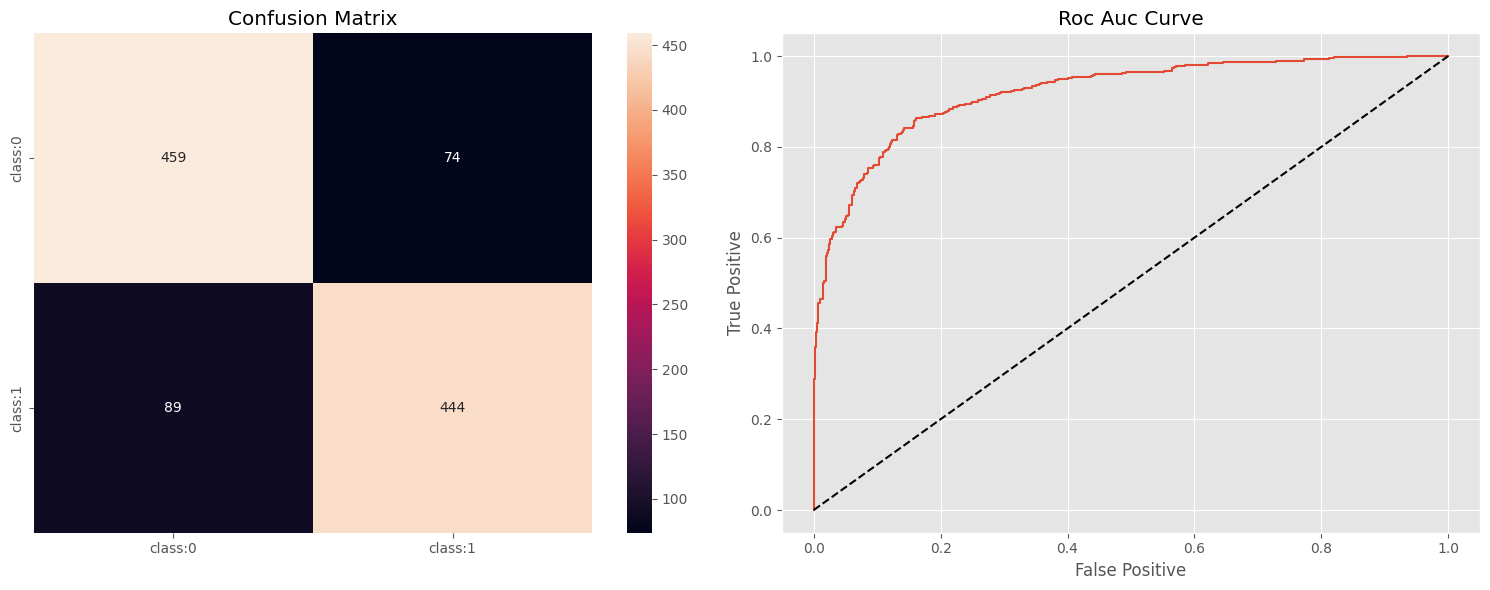

In [106]:
pytorch_trainer.evaluate(test_dataloader)